<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Accumulate_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [0]:
!nvidia-smi

Mon May 25 04:25:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Run:AI Gradient Accumulation library
https://github.com/run-ai/runai/tree/master/runai/ga

In [0]:
!pip install runai

# Import Libraries

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet201
from keras.legacy import interfaces
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import runai.ga.keras

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

# Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 16
STEPS = 16
LR = 1e-3
EPOCHS = 100

# Data Preparation

In [0]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 50.82 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


In [0]:
metadata_path = '/content/ham10000-with-one-image-folder/HAM10000_metadata.csv'
img_path = '/content/ham10000-with-one-image-folder/HAM1000_images'

In [0]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
data = pd.read_csv(metadata_path)

In [0]:
num_examples = data.values.shape[0]

In [0]:
inputs = np.empty(shape=(num_examples, 224, 224, 3), dtype=np.float32)
labels = np.empty(shape=(num_examples), dtype=np.uint8)

### Resize to 224*224

In [0]:
for i, row in enumerate(data.values):
    img_id = row[1]
    label = row[2]
    all_img_path = os.path.join(img_path, img_id) + '.jpg' 
    if (os.path.isfile(all_img_path)):
        im_path = all_img_path
    else:
        raise Exception ('File not found \'%s\'' %img_id)
    img = Image.open(im_path).resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
    inputs[i] = np.array(img)/255.0
    labels[i] = label_names.index(label)

### Split Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=2019)

del inputs
del labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=2019)

In [0]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6309, 224, 224, 3) (6309,)
(2704, 224, 224, 3) (2704,)
(1002, 224, 224, 3) (1002,)


### Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=360,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

In [0]:
datagen.fit(x_train)

# Adam Accumulate

In [0]:
optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [25-05-2020 04:35:43.678] [136] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# Build Model

In [0]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, kernel_regularizer=l2(1e-3))(x)
x = Dense(32, kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.25)(x)
preds = Dense(7,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=preds)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



74842112/74836368 [==============================] - 1s 0us/step


In [62]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='acc_densenet201_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-5 , patience=10, verbose=1, min_delta=1e-4, mode='min')

### Training

In [0]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=compute_class_weight('balanced', np.unique(y_train), y_train),
                              steps_per_epoch=math.ceil(x_train.shape[0]/BATCH_SIZE),
                              epochs=EPOCHS,
                              callbacks=[early_stop, model_checkpoint, reduce_lr_rate])


Epoch 1/100
395/395 [==============================] - 259s 656ms/step - loss: 1.2605 - accuracy: 0.6562 - val_loss: 2.0975 - val_accuracy: 0.7430
Epoch 2/100
395/395 [==============================] - 151s 381ms/step - loss: 0.8544 - accuracy: 0.7336 - val_loss: 1.3104 - val_accuracy: 0.7881
Epoch 3/100
395/395 [==============================] - 151s 382ms/step - loss: 0.7809 - accuracy: 0.7546 - val_loss: 1.8434 - val_accuracy: 0.7833
Epoch 4/100
395/395 [==============================] - 151s 383ms/step - loss: 0.7404 - accuracy: 0.7689 - val_loss: 1.2851 - val_accuracy: 0.8092
Epoch 5/100
395/395 [==============================] - 150s 381ms/step - loss: 0.7083 - accuracy: 0.7789 - val_loss: 1.6197 - val_accuracy: 0.7822
Epoch 6/100
395/395 [==============================] - 151s 383ms/step - loss: 0.6851 - accuracy: 0.7855 - val_loss: 1.0846 - val_accuracy: 0.8066
Epoch 7/100
395/395 [==============================] - 148s 375ms/step - loss: 0.6356 - accuracy: 0.8057 - val_loss: 

# Graph

### Accuracy

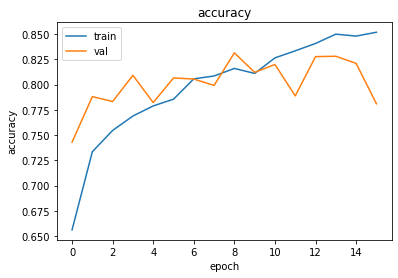

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### Loss

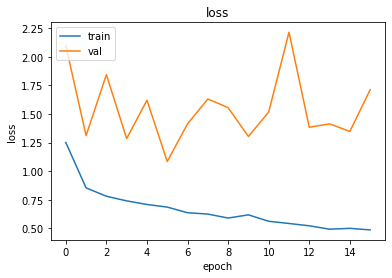

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = load_model('/content/acc_densenet201_model.h5', compile=False)

In [0]:
y_pred = np.argmax(test_model.predict(x_test), axis=1)
print('balanced acc on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

balanced acc on test set: 0.6574557622866052


### Classification Report

In [0]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       akiec       0.53      0.43      0.47        21
         bcc       0.74      0.55      0.63        51
         bkl       0.64      0.65      0.64       120
          df       0.33      0.43      0.38         7
         mel       0.64      0.66      0.65       116
          nv       0.90      0.89      0.90       678
        vasc       0.30      1.00      0.46         9

    accuracy                           0.81      1002
   macro avg       0.58      0.66      0.59      1002
weighted avg       0.82      0.81      0.81      1002



### Confusion Matrix

Confusion matrix, without normalization
[[  9   2   6   1   2   1   0]
 [  2  28  10   0   2   7   2]
 [  3   5  78   0   8  26   0]
 [  0   0   0   3   2   2   0]
 [  0   0  11   0  76  28   1]
 [  3   3  17   5  28 604  18]
 [  0   0   0   0   0   0   9]]


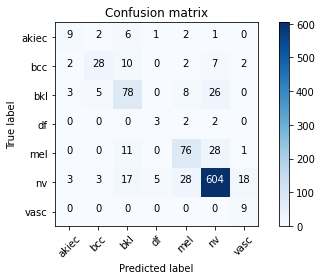

In [61]:
cm = (confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(cm, label_names)

### Sensitivity & Specificity

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [0]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.8182
specificity: 0.9333


# Grad-CAM

In [0]:
last_conv2d = 'conv5_block32_2_conv'

### AKIEC

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 1.000
	nv             	(5)	with probability 0.000
	vasc           	(6)	with probability 0.000
	bcc            	(1)	with probability 0.000
	bkl            	(2)	with probability 0.000
Explanation for 'mel'


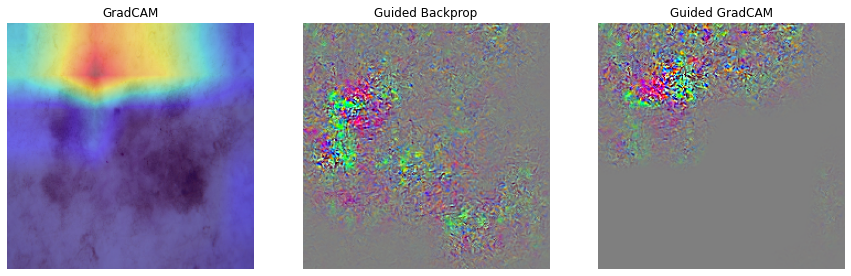

In [66]:
radcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)